<a href="https://colab.research.google.com/github/jimmiemunyi/deeplearning-experiments/blob/main/notebooks/MNIST_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We will be solving the full [MNIST DataSet](http://yann.lecun.com/exdb/mnist/) writing the code from Scratch.

Import Packages we will use:

In [1]:
!pip install -Uqq fastai

In [2]:
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

Downloading and extract the data. We will use the dataset hosted on [fastai datasets](https://course.fast.ai/datasets).

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
Path.BASE_PATH = path

Check the content of our folders:

In [5]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [6]:
(path/'training').ls().sorted()

(#10) [Path('training/0'),Path('training/1'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/5'),Path('training/6'),Path('training/7'),Path('training/8'),Path('training/9')]

In [7]:
(path/'testing').ls().sorted()

(#10) [Path('testing/0'),Path('testing/1'),Path('testing/2'),Path('testing/3'),Path('testing/4'),Path('testing/5'),Path('testing/6'),Path('testing/7'),Path('testing/8'),Path('testing/9')]

The data has been arranged in folders: `training` and `testing`, each with folders for each type of image `0-9`.

# Data Preprocessing

Writing custom functions to get our data.

`load_mnist_data` does the following:


*   scans the directories and get the labels
*   creates X and y lists for holding the independent and dependent variables respectively
*   for each file in a label folder, open the Image and append it to x, and append its label to y
*   stacks all the images into a tensor, casts them to float and normalize the data to be between 0 and 1
*   turn y (dependent variable) into a tensor
*   return X and y



In [8]:
def load_mnist_data(dataset, path):

  # scan all the directories and create a list of labels
  labels = os.listdir(path/dataset)
  labels.sort()

  # create lists for samples and labels
  X = []
  y = []

  # for each label folder
  for label in labels:
    # and for each image in given folder
    for file in (path/dataset/label).ls().sorted():
    # open the image and append it and labels to lists
      image = Image.open(file)
      X.append(tensor(image))
      y.append(int(label))
  # stack all the images into a tensor
  # and casts them into floats and 
  # normalizes them to between 0 and 1
  X = torch.stack(X).float()/255
  # turn y into tensor 
  y = tensor(y)
  return X, y
      

`create_data` loads the training and testing data, shuffles the training data and splits for validation data (using the percentage inputed as a parameter), flattens the X's, loads the data into datesets and returns them

In [9]:
def create_data(path, valid_split=0.2):

  # load the training and testing dataset separately
  X, y = load_mnist_data('training', path)
  X_test, y_test = load_mnist_data('testing', path)

  # shuffle the training data
  # because I want to split for validation data
  idx = torch.randperm(X.shape[0])
  X = X[idx].view(X.size())
  y = y[idx].view(y.size())

  # Flatten the Training Images and Test Images
  X = X.view(-1, 28*28)
  X_test = X_test.view(-1, 28*28)

  # default split is 20% 
  # but can be changed by parameter
  train_index = int((1-valid_split) * X.shape[0])
  X_train = X[:train_index]
  y_train = y[:train_index]
  X_valid = X[train_index:]
  y_valid = y[train_index:]

  # load the data into respective datasets
  train = list(zip(X_train, y_train))
  valid = list(zip(X_valid, y_valid))
  test = list(zip(X_test, y_test))

  # return the datasets
  return train, valid, test

## DataSet

Create the training, validation and testing datasets:

In [10]:
train_dset, valid_dset, test_dset = create_data(path)

In [11]:
len(train_dset), len(valid_dset), len(test_dset)

(48000, 12000, 10000)

## DataLoaders

Create `DataLoaders` of the training and validation datasets.
DataLoaders object groups the data in batches and shuffles the training data. 

In [12]:
train_dl = DataLoader(train_dset, bs=256, shuffle=True)
valid_dl = DataLoader(valid_dset, bs=256, shuffle=False)

dls = DataLoaders(train_dl, valid_dl)

In [13]:
len(train_dl), len(valid_dl)

(188, 47)

# Loss Function

Create the Loss Function we are going to use. We are using CrossEntropy Loss. It applies softmax along the columns. Then for each true label y, we get the activtion of our model in that index, apply negative log and return the mean of all the log likelihoods.

In [14]:
def cross_entropy_loss(preds, y):
  # apply softmax
  preds = torch.softmax(preds, axis=1)

  # get confidences for the correct class
  idx = len(preds)
  confidences = preds[range(idx), y]
  
  # calculate negative log likelihood and return it
  log_ll =  -torch.log(confidences)
  return log_ll.mean()

# Testing with a Small Batch of Data First

First test with a small batch of 5.

In [15]:
batch = train_dset[:5]

In [16]:
data = [list(t) for t in zip(*batch)]
x, y = data[0], data[1]

xb = torch.stack(x)
yb = torch.stack(y)

In [17]:
xb.shape, yb.shape

(torch.Size([5, 784]), torch.Size([5]))

## Simple Model

Create a Simple Model and a way to initialize parameters:

In [18]:
def init_params(size):
  # we initialize them randomly
  return (torch.randn(size)).requires_grad_()

def linear_model(xb):
  return xb@weights + biases

In [19]:
weights = init_params((28*28, 10))
biases = init_params(10)

Get the prediction using our simple model

In [20]:
preds = linear_model(xb)
preds

tensor([[-15.5316, -10.6311,  17.8504,  -2.2966,  -9.2023, -13.0675,   7.2907,
           3.0064,  -5.4461, -13.5227],
        [-20.1133, -11.3326,   1.8361,  -0.9149,  -6.0363,  -0.9184,   8.4763,
          16.4081,   1.5354,  -0.6634],
        [-11.0580,  -4.9101,   6.2878,  12.4676,  -5.4848,   7.6617,  13.7218,
           6.9204,   2.6186,  -8.8912],
        [  5.1292,  -6.9744,  17.0552,   1.3707,   8.9145,  -3.7647,  -2.5044,
          -1.1342,  21.8447,   6.5467],
        [-26.1427,   1.8682,  14.8014,   4.7678,  -3.2687,   9.4919,   4.0314,
           1.9956,  -2.7949,  -7.6126]], grad_fn=<AddBackward0>)

Calculate the Loss:

In [21]:
loss = cross_entropy_loss(preds, yb)
loss

tensor(20.5296, grad_fn=<MeanBackward0>)

Let's put that in a function:

In [22]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = cross_entropy_loss(preds, yb)
  loss.backward()

Get the mean weights and biases gradients (because we can't display all of them)

In [23]:
calc_grad(xb, yb, linear_model)
weights.grad.mean(), biases.grad.mean()

(tensor(7.2985e-10), tensor(1.4901e-09))

Create a function to train for one epoch with our training data

In [24]:
def train_epoch(model, lr, params):
  for xb, yb in train_dl:
    calc_grad(xb, yb, model)
    for p in params:
      p.data -= p.grad*lr
      p.grad.zero_()

## Accuracy Function

Define the accuracy function we are going to use. It gets the index of the largest activation of the predictions assumes thats what out model predicts, and compares them with the true labels and get the mean.

In [25]:
def batch_accuracy(preds, yb):
  prediction = torch.argmax(preds, axis=1)
  correct = (prediction == yb)
  return correct.float().mean()

Current accuracy of our simple model on the small batch:

In [26]:
batch_accuracy(linear_model(xb), yb)

tensor(0.)

Create a function for validating an epoch. Remember we get the metrics on the validation dataset.

In [27]:
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

Current accuracy on validation set:

In [28]:
validate_epoch(linear_model)

0.1119

Step the model once:

In [29]:
lr = 1
params = weights, biases
train_epoch(linear_model, lr, params)
validate_epoch(linear_model)

0.837

Loop for a number of epochs and train and validate:

In [30]:
for i in range(20):
  train_epoch(linear_model, lr, params)
  print(validate_epoch(linear_model), end=' ')

0.8649 0.8752 0.8786 0.8848 0.8882 0.8945 0.89 0.896 0.9003 0.9 0.8939 0.9029 0.9014 0.8925 0.9055 0.9064 0.9055 0.9039 0.9083 0.9074 

# Optimizer Class

Create an optimzer class. We are going to use Basic SGD.

In [31]:
class optimizer_SGD():
  def __init__(self,params,lr): 
    self.params = list(params)
    self.lr = lr
  
  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= p.grad.data * self.lr
    
  def zero_grad(self, *args, **kwargs):
    for p in self.params:
      p.grad = None

We use the Linear model provided by PyTorch:

In [32]:
model = nn.Linear(28*28, 10)

In [33]:
w, b = model.parameters()
w.shape, b.shape

(torch.Size([10, 784]), torch.Size([10]))

Function to train an epoch:

In [34]:
def train_epoch(model):
    for xb,yb in train_dl:
        calc_grad(xb, yb, model)
        optimizer.step()
        optimizer.zero_grad()

Function of training the whole model:

In [35]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

Initialize the optimizer

In [36]:
optimizer = optimizer_SGD(model.parameters(), lr)

Train the model for 20 epochs.

In [37]:
train_model(model, 20)

0.9008 0.9079 0.9147 0.9145 0.9127 0.9128 0.9205 0.9203 0.9214 0.921 0.9154 0.9228 0.9219 0.9192 0.9208 0.9208 0.9125 0.9194 0.9161 0.918 

Our simple linear model is training! Next, let's make a Neural Network

# Adding Non-Linearity

We create a simple neural network by adding a non-linearity (ReLU) between the Dense/Linear layers

In [38]:
model = nn.Sequential(
    nn.Linear(28*28, 60),
    nn.ReLU(),
    nn.Linear(60, 10)
)

In [39]:
optimizer = optimizer_SGD(model.parameters(), lr)

In [40]:
train_model(model, 20)

0.9293 0.9463 0.9513 0.9573 0.9575 0.9627 0.9631 0.9652 0.9631 0.9664 0.9666 0.9618 0.9679 0.9648 0.9697 0.9691 0.968 0.9482 0.9704 0.971 

We got a higher accuracy than with just a linear model.

# Custom Learner Class

Let's create a Custom Learner class like the one provided by fastai.

The `Custom_Learner` brings all the following into one class:


*   DataLoaders
*   The Model
*   The Loss Function to use
*   The Optimizer
*   Metrics you want printed out (currently only batch accuracy works)!

It then provides a fit method to train your model for the number of epochs you want. It prints out a bunch of important stuff that give you information about how your model is training.

It provides two methods `plot_loss` and `plot_accuracy` to plot loss and accuracy respectively




In [41]:
class Custom_Learner():
  
  # initialize the class
  def __init__(self, dls=None, model=None, loss_func=None, opt=None, metrics=None):
    self.train_dl, self.valid_dl = dls
    self.model = model
    self.loss_func = loss_func
    self.opt = opt
    self.metrics = metrics

    # for printing purposes
    self._epoch = 0.
    self._tloss = 0.
    self._vloss = 0.
    self._met = 0.

    # for plotting purposes
    self._epochs = []
    self._tlosses = []
    self._vlosses = []
    self._accuracies = []

  # the fit method is used to train the model
  def fit(self, epochs=None, lr=None):
    self.lr = lr
    self.train_model(self.model, epochs)
  
  # train epoch
  def train_epoch(self, model):
    for xb, yb in self.train_dl:
      predictions = model(xb)
      loss = self.loss_func(predictions, yb)
      self._tloss = round(loss.item(), 4)
      loss.backward()
      self.opt.step()
      self.opt.zero_grad()
    
    for xb, yb in self.valid_dl:
      predictions = model(xb)
      loss = self.loss_func(predictions, yb)
      self._vloss = round(loss.item(), 4)
  
  # validate epoch
  def validate_epoch(self, model):
    accs = [self.metrics(model(xb), yb) for xb, yb in self.valid_dl]
    self._met = round(torch.stack(accs).mean().item(), 4)
  
  # print output as the model is training
  def show_output(self):
    print(f'epoch {self._epoch}: ' +
          f'train_loss: {self._tloss:.4f}, ' +
          f'valid_loss: {self._vloss:.4f}, ' +
          f'accuracy: {self._met:.4f}')
    
  # training the model
  def train_model(self, model, epochs):
    self.opt = self.opt(self.model.parameters(), self.lr)
    for i in range(epochs):
      self._epoch = i
      # train the model
      self.train_epoch(self.model)
      # validate the model and print out metrics
      self.validate_epoch(self.model)
      self.update_accuracies(self._met)
      self.update_tlosses(self._tloss)
      self.update_vlosses(self._vloss)
      self.update_epochs(self._epoch+1)
      self.show_output()
  
  # update accuracies
  def update_accuracies(self, accuracy):
    self._accuracies.append(accuracy)
  
  # update losses
  def update_tlosses(self, loss):
    self._tlosses.append(loss)
  
  # update losses
  def update_vlosses(self, loss):
    self._vlosses.append(loss)
  
  # update epochs
  def update_epochs(self, epoch):
    self._epochs.append(epoch)

  # plot losses
  def plot_loss(self):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(self._epochs, self._tlosses, label='Training Loss')
    ax.plot(self._epochs, self._vlosses, color='Orange', label='Validation Loss')
    ax.set_title('Loss in Training and Validation')
    ax.set_ylabel('loss')
    ax.set_xlabel('epochs')
    ax.legend()

  # plot accuracies
  def plot_accuracy(self):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(self._epochs, self._accuracies, label='Valiadtion Accuracy')
    ax.set_title('Accuracy in Validation')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epochs')
    ax.legend()


Initialize the learner and train a linear model for 10 epochs:

In [42]:
learn = Custom_Learner(dls=dls, model=nn.Linear(28*28,10), loss_func=cross_entropy_loss, opt=optimizer_SGD, metrics=batch_accuracy)

In [43]:
learn.fit(10, lr=1)

epoch 0: train_loss: 0.3706, valid_loss: 0.2796, accuracy: 0.9109
epoch 1: train_loss: 0.2508, valid_loss: 0.2883, accuracy: 0.9076
epoch 2: train_loss: 0.4484, valid_loss: 0.2582, accuracy: 0.9165
epoch 3: train_loss: 0.3537, valid_loss: 0.2483, accuracy: 0.9164
epoch 4: train_loss: 0.2857, valid_loss: 0.2546, accuracy: 0.9192
epoch 5: train_loss: 0.2045, valid_loss: 0.2559, accuracy: 0.9148
epoch 6: train_loss: 0.2076, valid_loss: 0.2447, accuracy: 0.9158
epoch 7: train_loss: 0.1970, valid_loss: 0.2422, accuracy: 0.9195
epoch 8: train_loss: 0.1715, valid_loss: 0.2547, accuracy: 0.9160
epoch 9: train_loss: 0.2693, valid_loss: 0.2322, accuracy: 0.9160


Create a Neural Network with two layers of 60 neurons and 10 neurons (for the output) respectively. Create a learner using the neural network and train for 40 epochs:

In [44]:
neural_net = nn.Sequential(
    nn.Linear(28*28, 60),
    nn.ReLU(),
    nn.Linear(60, 10)
)

In [45]:
neural_learn = Custom_Learner(dls=dls, model=neural_net, loss_func=cross_entropy_loss, opt=optimizer_SGD, metrics=batch_accuracy)

In [46]:
neural_learn.fit(40, lr=0.1)

epoch 0: train_loss: 0.4239, valid_loss: 0.4006, accuracy: 0.8825
epoch 1: train_loss: 0.2300, valid_loss: 0.3011, accuracy: 0.9073
epoch 2: train_loss: 0.2636, valid_loss: 0.2615, accuracy: 0.9180
epoch 3: train_loss: 0.2565, valid_loss: 0.2420, accuracy: 0.9226
epoch 4: train_loss: 0.2206, valid_loss: 0.2254, accuracy: 0.9283
epoch 5: train_loss: 0.3110, valid_loss: 0.2263, accuracy: 0.9304
epoch 6: train_loss: 0.2015, valid_loss: 0.2102, accuracy: 0.9362
epoch 7: train_loss: 0.2987, valid_loss: 0.2004, accuracy: 0.9405
epoch 8: train_loss: 0.2189, valid_loss: 0.1790, accuracy: 0.9446
epoch 9: train_loss: 0.1389, valid_loss: 0.1765, accuracy: 0.9457
epoch 10: train_loss: 0.1456, valid_loss: 0.1770, accuracy: 0.9474
epoch 11: train_loss: 0.2793, valid_loss: 0.1609, accuracy: 0.9493
epoch 12: train_loss: 0.2271, valid_loss: 0.1657, accuracy: 0.9500
epoch 13: train_loss: 0.1864, valid_loss: 0.1446, accuracy: 0.9530
epoch 14: train_loss: 0.0962, valid_loss: 0.1370, accuracy: 0.9544
epoch

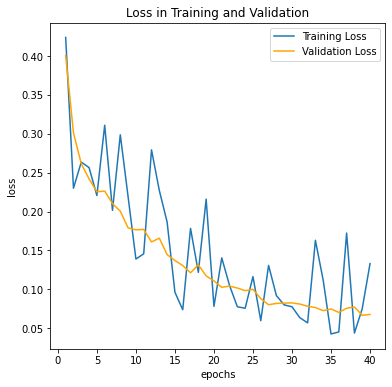

In [47]:
neural_learn.plot_loss()

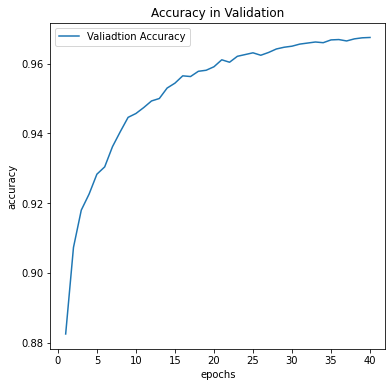

In [48]:
neural_learn.plot_accuracy()

# Using Classes provided by fastai and PyTorch

Do the same with classes provided by fastai and PyTorch:

In [49]:
neural_net = nn.Sequential(
    nn.Linear(28*28, 60),
    nn.ReLU(),
    nn.Linear(60, 10)
)

In [50]:
learn = Learner(dls=dls, model=neural_net, loss_func=cross_entropy_loss, opt_func=SGD, metrics=batch_accuracy)

learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.561933,0.422098,0.887500,00:01
1,0.372078,0.346315,0.897250,00:01
2,0.324683,0.306344,0.912167,00:01
3,0.297180,0.274739,0.922167,00:01
4,0.266952,0.261741,0.926000,00:01
5,0.252166,0.247402,0.930417,00:01
6,0.240814,0.228739,0.936667,00:01
7,0.221981,0.217711,0.940000,00:01
8,0.212957,0.211853,0.938500,00:01
9,0.203334,0.201231,0.944583,00:01


It does the exact same thing as our from scratch. This just shows the classes provided by Frameworks are not magic!

# Test Set

Let us work on our test set that we set aside.

In [51]:
len(test_dset)

10000

In [52]:
testing_data = [list(t) for t in zip(*test_dset)]
x, y = testing_data[0], testing_data[1]

xtest = torch.stack(x)
ytest = torch.stack(y)

Get the model from our `neural_learn` Learner:

In [53]:
neural_learn.model

Sequential(
  (0): Linear(in_features=784, out_features=60, bias=True)
  (1): ReLU()
  (2): Linear(in_features=60, out_features=10, bias=True)
)

Create a function to run inference on the test set:

In [54]:
def inference(model, x, y):
  acts = model(x)
  predictions = torch.argmax(acts, axis=1)
  correct = (predictions == y)
  return (correct.float().mean()).item()

In [55]:
test_accuracy = inference(neural_learn.model, xtest, ytest)
print(f'Our Final Accuracy on the Test set is: {test_accuracy:.4f}')

Our Final Accuracy on the Test set is: 0.9703


That's our final accuracy on the test set!